In [55]:
from spleeter.separator import Separator
import os
import librosa
from swift_f0 import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# import compiam

In [56]:
audio_path = '/Users/saumyamishra/Desktop/intern/summer25/RagaDetection/audio/mohan.mp3'
# inputs
# audio_path = '/Users/saumyamishra/Desktop/intern/summer25/RagaDetection/RagaDataset/Hindustani/audio/Gaud Malhar/Gaud Malhar_9.mp3'
fusion = False  # whether song is fusion or pure classical
output_dir = 'separated_stems'        # saved stems directory
filename = os.path.splitext(os.path.basename(audio_path))[0]
stem_dir = os.path.join(output_dir, filename)

# only run separation if the folder doesn't already exist
if not os.path.isdir(stem_dir):
    separator = Separator('spleeter:2stems')
    separator.separate_to_file(audio_path, output_dir)
else:
    print(f"Skipping separation: '{stem_dir}' already exists.")

# set the paths
vocals_path = os.path.join(stem_dir, 'vocals.wav')
accompaniment_path = os.path.join(stem_dir, 'accompaniment.wav')

print("Vocals:", vocals_path)
print("Accompaniment:", accompaniment_path)


Skipping separation: 'separated_stems/mohan' already exists.
Vocals: separated_stems/mohan/vocals.wav
Accompaniment: separated_stems/mohan/accompaniment.wav


In [57]:
tonic = 'C'
raga_name = 'Bhairav'

In [58]:
import os
from typing import Optional, Tuple

import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt

from swift_f0 import (
    SwiftF0,
    PitchResult,
    plot_pitch,
    export_to_csv,
    segment_notes,
    plot_notes,
    plot_pitch_and_notes,
    export_to_midi,
)

vocal_note_sequence = None


def load_swiftf0_csv_as_pitchresult(csv_path: str, silent: bool = False) -> PitchResult:
    """Load a CSV exported by swift-f0 and return a defensive PitchResult instance."""
    df = pd.read_csv(csv_path)
    # accept 'time' or 'timestamp' for timing, 'voiced' or 'voicing' for voiced flag
    ts_col = "time" if "time" in df.columns else ("timestamp" if "timestamp" in df.columns else None)

    pitch_col = "pitch_hz" if "pitch_hz" in df.columns else None
    conf_col = "confidence" if "confidence" in df.columns else None
    voiced_col = "voicing" if "voicing" in df.columns else ("voiced" if "voiced" in df.columns else None)

    if pitch_col is None or conf_col is None:
        raise ValueError(f"CSV {csv_path} missing required columns. Found: {list(df.columns)}")

    timestamps = pd.to_numeric(df[ts_col], errors="coerce").to_numpy() if ts_col else np.arange(len(df)).astype(float)
    pitch_hz = pd.to_numeric(df[pitch_col], errors="coerce").to_numpy()
    pitch_hz = np.nan_to_num(pitch_hz, nan=0.0)
    confidence = pd.to_numeric(df[conf_col], errors="coerce").to_numpy()
    confidence = np.nan_to_num(confidence, nan=0.0)

    if voiced_col:
        voiced_raw = df[voiced_col].astype(str).fillna("").str.strip().str.lower()

        def parse_bool(x: str) -> bool:
            if x == "" or x == "nan":
                return False
            if x in ("1", "1.0", "true", "t", "yes", "y"):
                return True
            if x in ("0", "0.0", "false", "f", "no", "n"):
                return False
            try:
                return bool(int(float(x)))
            except Exception:
                return False

        voiced = np.array([parse_bool(x) for x in voiced_raw], dtype=bool)
    else:
        voiced = (pitch_hz > 0) & (confidence > 0)

    # frame_period if available via 'frame_rate' or infer from timestamps
    frame_period = None
    if "frame_rate" in df.columns:
        try:
            frame_period = 1.0 / float(df["frame_rate"].iloc[0])
        except Exception:
            frame_period = None
    elif ts_col:
        times = pd.to_numeric(df[ts_col], errors="coerce").to_numpy()
        if len(times) > 1:
            diffs = np.diff(times[: min(50, len(times))])
            frame_period = float(np.median(diffs)) if diffs.size else None

    pr = PitchResult(pitch_hz=pitch_hz, confidence=confidence, timestamps=timestamps, voicing=voiced)
    setattr(pr, "frame_period", frame_period)
    if not silent:
        print(
            f"[LOAD CSV] {os.path.basename(csv_path)} -> PitchResult (frames={len(pitch_hz)}, voiced={int(voiced.sum())})"
        )
    return pr


def _apply_override_confidence(pr: PitchResult, threshold: float) -> None:
    """Replace/override pr.voicing using the provided confidence threshold."""
    conf = getattr(pr, "confidence", None)
    pitch = getattr(pr, "pitch_hz", None)
    if conf is None or pitch is None or len(conf) != len(pitch):
        print("[WARN] Cannot apply override_confidence_threshold: inconsistent or missing arrays.")
        return
    new_voicing = (pitch > 0) & (conf >= threshold)
    setattr(pr, "voicing", new_voicing)
    print(f"[INFO] Applied override_confidence_threshold = {threshold} (voiced frames = {int(new_voicing.sum())})")


def analyze_or_load_with_plots(
    stem_path: str,
    detector: SwiftF0,
    output_prefix: str = "output",
    num_bins: int = 25,
    save_midi: bool = True,
    force_recompute: bool = False,
    store_as_vocal: bool = False,
    start_time: float = 0.0,
    duration: Optional[float] = None,
    override_confidence_threshold: Optional[float] = None,
) -> Tuple[PitchResult, np.ndarray, np.ndarray, np.ndarray]:
    """
    Main pipeline wrapper.
    - If <stem_dir>/<output_prefix>_pitch_data.csv exists and force_recompute is False -> load CSV.
      Otherwise run SwiftF0 on the audio slice (offset=start_time, duration=duration).
    - Optionally override voicing via override_confidence_threshold (applied even when CSV is loaded).
    - Runs plotting, segmentation, MIDI export and returns (pr, valid_frequencies, cent_hist, midi_vals).
    """
    global vocal_note_sequence

    stem_dir = os.path.dirname(stem_path) or "."
    csv_path = os.path.join(stem_dir, f"{output_prefix}_pitch_data.csv")
    midi_npy_path = os.path.join(stem_dir, f"{output_prefix}_midi.npy")
    midi_csv_path = os.path.join(stem_dir, f"{output_prefix}_midi.csv")

    pr: Optional[PitchResult] = None
    sr: Optional[int] = None

    if os.path.isfile(csv_path) and not force_recompute:
        try:
            pr = load_swiftf0_csv_as_pitchresult(csv_path)
        except Exception as e:
            print(f"[WARN] Failed to load CSV {csv_path}: {e}. Will recompute.")
            pr = None

    # run detector if needed
    if pr is None:
        print(f"[RUN] Running SwiftF0 for {stem_path} (start={start_time}, duration={duration})")
        y, sr = librosa.load(stem_path, sr=None, offset=start_time, duration=duration)
        pr = detector.detect_from_array(y, sr)
        try:
            export_to_csv(pr, csv_path)
            print(f"[WRITE] Exported CSV: {csv_path}")
        except Exception as e:
            print(f"[WARN] export_to_csv failed: {e}")

    # override voicing using confidence (works whether loaded or recomputed)
    if override_confidence_threshold is not None:
        _apply_override_confidence(pr, override_confidence_threshold)

    # plot pitch (always run to update visuals)
    try:
        plot_pitch(pr, show=False, output_path=os.path.join(stem_dir, f"{output_prefix}_pitch.jpg"))
    except Exception as e:
        print(f"[WARN] plot_pitch failed: {e}")

    # Note segmentation + plots + MIDI export
    notes = []
    try:
        notes = segment_notes(pr, split_semitone_threshold=0.8, min_note_duration=0.1)

        if store_as_vocal:
            vocal_note_sequence = [
                {"start": note.start, "end": note.end, "pitch_hz": note.pitch_median, "midi_note": note.pitch_midi}
                for note in notes
            ]

        try:
            plot_notes(notes, output_path=os.path.join(stem_dir, f"{output_prefix}_note_segments.jpg"))
        except Exception as e:
            print(f"[WARN] plot_notes failed: {e}")

        try:
            plot_pitch_and_notes(pr, notes, output_path=os.path.join(stem_dir, f"{output_prefix}_combined_analysis.jpg"))
        except Exception as e:
            print(f"[WARN] plot_pitch_and_notes failed: {e}")

        try:
            export_to_midi(notes, os.path.join(stem_dir, f"{output_prefix}_notes.mid"))
        except Exception as e:
            print(f"[WARN] export_to_midi failed: {e}")

    except Exception as e:
        print(f"[WARN] segment_notes failed or returned no notes: {e}")
        notes = []

    # Extract voiced frames robustly
    voiced_mask = getattr(pr, "voicing", None)
    pitch_hz_arr = getattr(pr, "pitch_hz", np.array([], dtype=float))
    conf_arr = getattr(pr, "confidence", None)

    if voiced_mask is not None and len(voiced_mask) == len(pitch_hz_arr):
        voiced_freqs = pitch_hz_arr[voiced_mask]
        voiced_confs = conf_arr[voiced_mask] if conf_arr is not None else np.ones_like(voiced_freqs)
    else:
        voiced_freqs = pitch_hz_arr
        voiced_confs = conf_arr if conf_arr is not None else np.ones_like(voiced_freqs)

    # Filter positives
    valid_mask = voiced_freqs > 0
    valid_frequencies = voiced_freqs[valid_mask]
    valid_confidences = voiced_confs[valid_mask] if np.size(voiced_confs) else np.array([])

    # Frame duration
    frame_period = getattr(pr, "frame_period", None)
    if frame_period is None:
        if sr is not None:
            frame_period = 512.0 / float(sr)
        else:
            frame_period = 0.01
    weights = (valid_confidences * frame_period) if valid_confidences.size else np.array([])

    # MIDI values (load or compute and save)
    midi_vals = None
    if save_midi and os.path.isfile(midi_npy_path) and not force_recompute:
        try:
            midi_vals = np.load(midi_npy_path)
            print(f"[LOAD] MIDI npy loaded: {midi_npy_path} (len={len(midi_vals)})")
        except Exception as e:
            print(f"[WARN] Failed to load MIDI npy: {e}. Will recompute MIDI.")
            midi_vals = None

    if midi_vals is None:
        if valid_frequencies.size:
            midi_vals = librosa.hz_to_midi(valid_frequencies)
        else:
            midi_vals = np.array([], dtype=float)
        if save_midi:
            try:
                np.save(midi_npy_path, midi_vals)
                pd.DataFrame({"midi": np.round(midi_vals, 6)}).to_csv(midi_csv_path, index=False)
                print(f"[WRITE] Saved MIDI -> {midi_npy_path}, {midi_csv_path}")
            except Exception as e:
                print(f"[WARN] Failed to save MIDI files: {e}")

    # MIDI summary
    if midi_vals.size:
        midi_preview = np.round(midi_vals[:40], 2).tolist()
        pitch_classes = np.mod(np.round(midi_vals), 12).astype(int)
        print(f"\n{output_prefix} — voiced (valid) frames: {len(midi_vals)}")
        print("MIDI preview (first up to 40):", midi_preview)
        print("Unique pitch-classes:", sorted(np.unique(pitch_classes).tolist()))
        print("MIDI mean {:.2f}, median {:.2f}, std {:.2f}\n".format(np.mean(midi_vals), np.median(midi_vals), np.std(midi_vals)))
    else:
        print(f"\n{output_prefix} — no valid voiced frames found. MIDI empty.\n")

    # Cent histogram (weighted) and save plots
    if valid_frequencies.size:
        midi_vals_full = librosa.hz_to_midi(valid_frequencies)
        cent_values = (midi_vals_full % 12) * 100.0
        cent_hist, _ = np.histogram(cent_values, bins=num_bins, range=(0, 1200), weights=weights if weights.size else None)
    else:
        cent_hist = np.zeros(num_bins, dtype=float)

    bin_width = 1200.0 / num_bins
    plt.figure(figsize=(12, 4))
    plt.bar(np.arange(num_bins), cent_hist, width=1.0, alpha=0.8)
    plt.title(f"{output_prefix}: Weighted Cent Histogram ({num_bins} bins, {bin_width:.1f}¢/bin)")
    plt.xlabel("Bin index")
    plt.ylabel("Weighted Seconds")
    step = max(1, num_bins // 12)
    ticks = np.arange(0, num_bins, step)
    labels = [f"{int(i * bin_width)}¢" for i in ticks]
    plt.xticks(ticks=ticks, labels=labels, rotation=45)
    plt.grid(axis="x", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(os.path.join(stem_dir, f"{output_prefix}_cent_histogram.jpg"))
    plt.show()
    plt.close()

    # Frequency histogram
    plt.figure(figsize=(12, 4))
    plt.hist(valid_frequencies, bins=1200, alpha=0.8, weights=weights if weights.size else None)
    plt.title(f"{output_prefix}: Weighted Frequency Histogram of Voiced Frames")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Weighted Seconds")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(os.path.join(stem_dir, f"{output_prefix}_frequency_histogram.jpg"))
    plt.show()
    plt.close()

    return pr, valid_frequencies, cent_hist, midi_vals


-------Vocal analysis--------
[LOAD CSV] vocals_pitch_data.csv -> PitchResult (frames=7500, voiced=3188)
[INFO] Applied override_confidence_threshold = 0.95 (voiced frames = 3389)


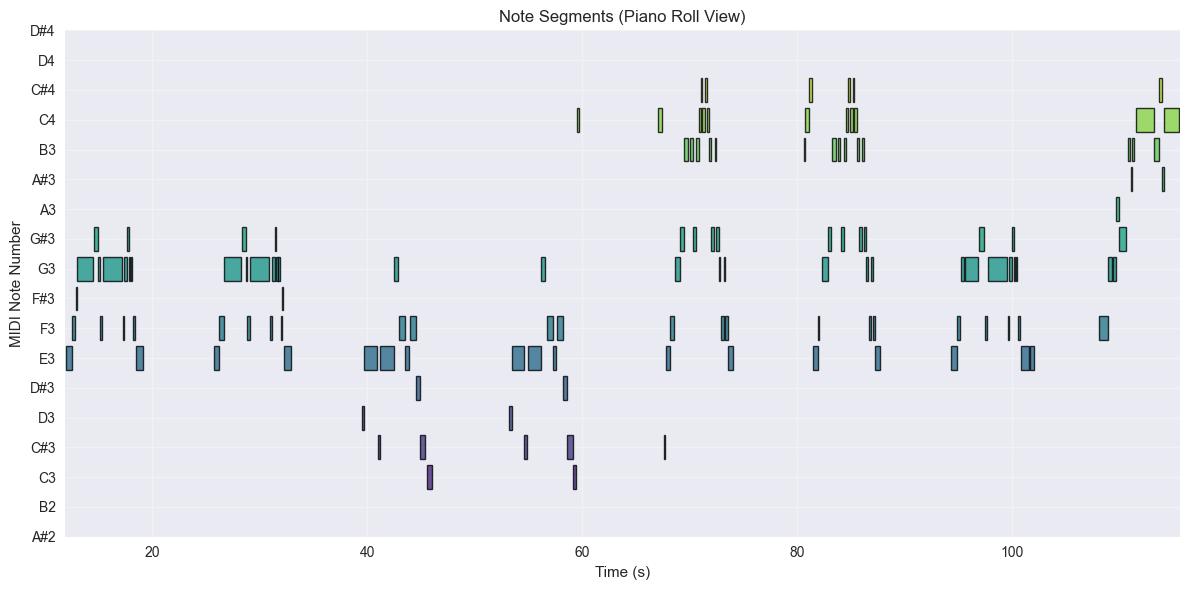

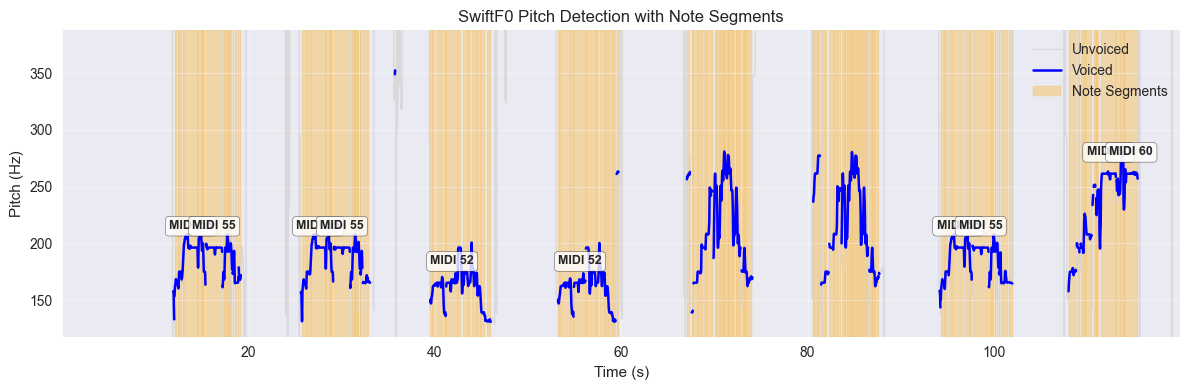

[LOAD] MIDI npy loaded: separated_stems/mohan/vocals_midi.npy (len=3389)

vocals — voiced (valid) frames: 3389
MIDI preview (first up to 40): [51.2400016784668, 51.25, 51.16999816894531, 50.7599983215332, 49.970001220703125, 48.9900016784668, 48.349998474121094, 48.290000915527344, 50.75, 51.38999938964844, 51.59000015258789, 51.70000076293945, 51.72999954223633, 51.88999938964844, 52.04999923706055, 52.13999938964844, 52.349998474121094, 52.369998931884766, 52.369998931884766, 52.29999923706055, 52.11000061035156, 52.04999923706055, 52.04999923706055, 52.04999923706055, 52.04999923706055, 52.04999923706055, 52.04999923706055, 52.04999923706055, 52.040000915527344, 51.939998626708984, 51.72999954223633, 51.70000076293945, 51.650001525878906, 51.52000045776367, 51.54999923706055, 51.779998779296875, 52.29999923706055, 52.709999084472656, 52.970001220703125, 53.040000915527344]
Unique pitch-classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
MIDI mean 54.64, median 54.96, std 3.02



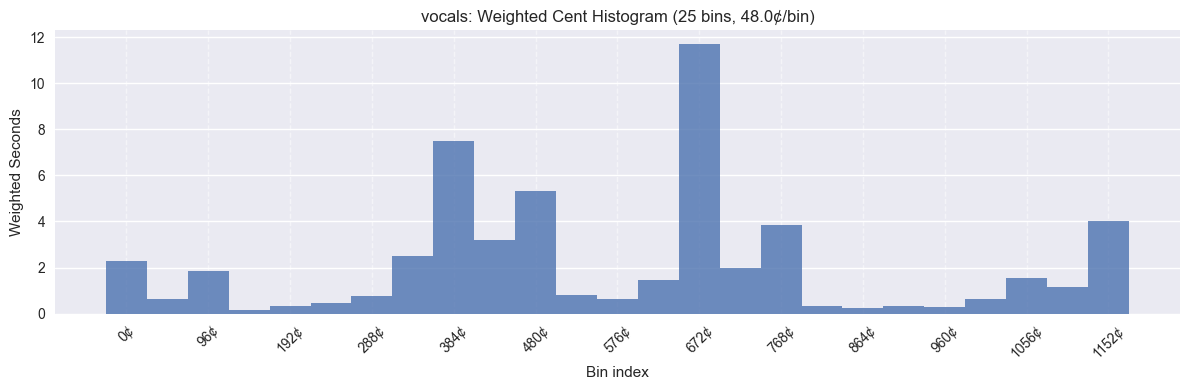

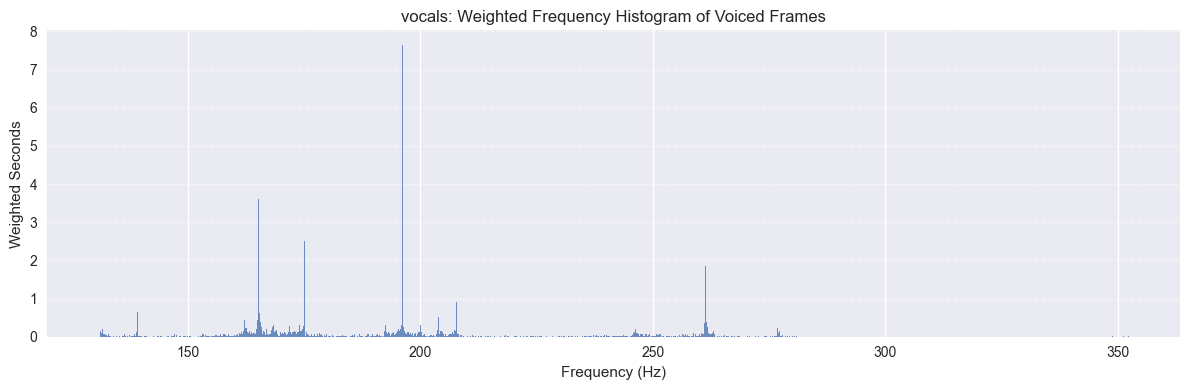

-------Accompaniment analysis --------
[LOAD CSV] accompaniment_pitch_data.csv -> PitchResult (frames=15972, voiced=4141)


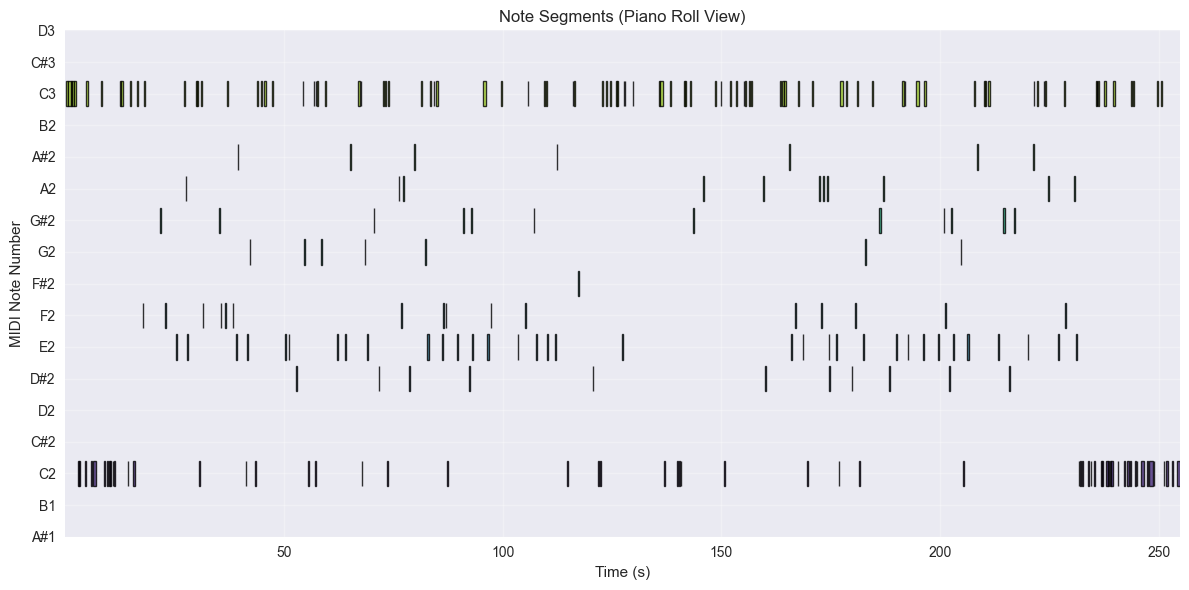

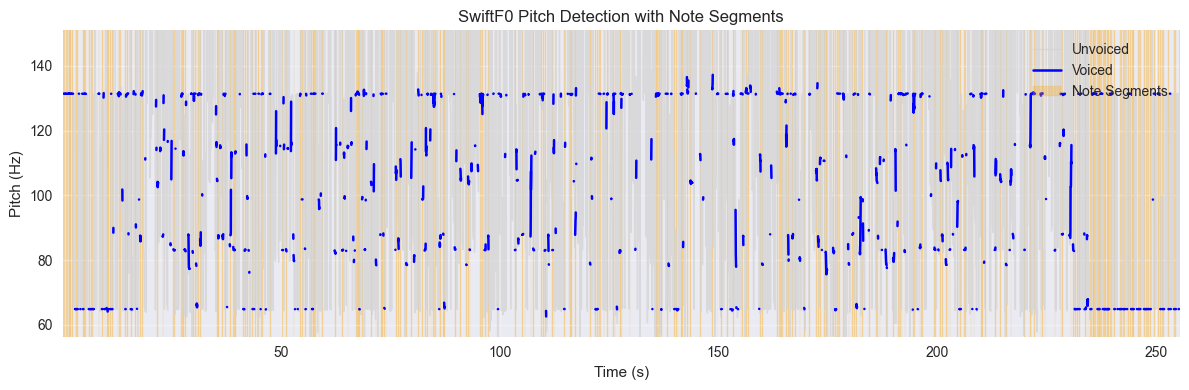

[LOAD] MIDI npy loaded: separated_stems/mohan/accompaniment_midi.npy (len=4141)

accompaniment — voiced (valid) frames: 4141
MIDI preview (first up to 40): [48.08000183105469, 48.08000183105469, 48.08000183105469, 48.08000183105469, 48.08000183105469, 48.08000183105469, 48.08000183105469, 48.08000183105469, 48.08000183105469, 48.08000183105469, 48.08000183105469, 48.08000183105469, 48.08000183105469, 48.08000183105469, 48.08000183105469, 48.08000183105469, 48.08000183105469, 48.08000183105469, 48.08000183105469, 48.08000183105469, 48.08000183105469, 48.08000183105469, 48.08000183105469, 48.08000183105469, 48.08000183105469, 48.08000183105469, 48.08000183105469, 48.08000183105469, 48.08000183105469, 48.08000183105469, 48.08000183105469, 48.08000183105469, 48.08000183105469, 48.08000183105469, 48.08000183105469, 48.08000183105469, 48.08000183105469, 48.08000183105469, 48.08000183105469, 48.08000183105469]
Unique pitch-classes: [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11]
MIDI mean 43.05, median 4

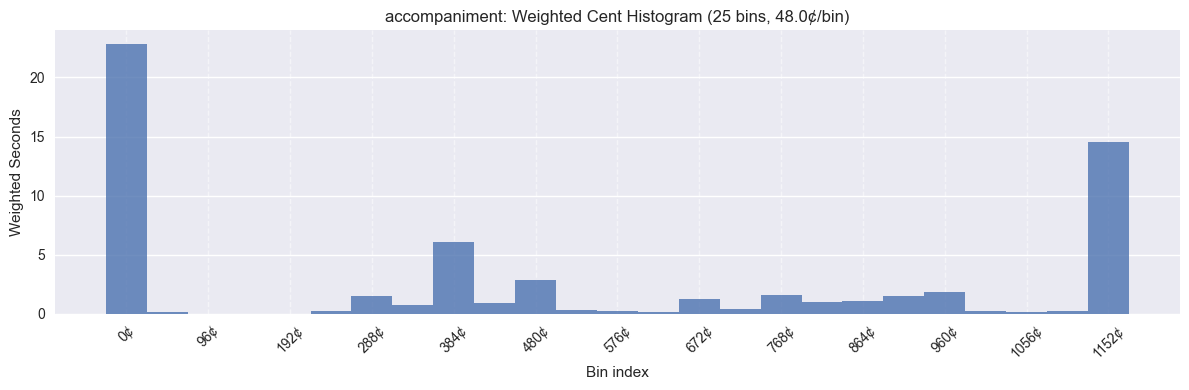

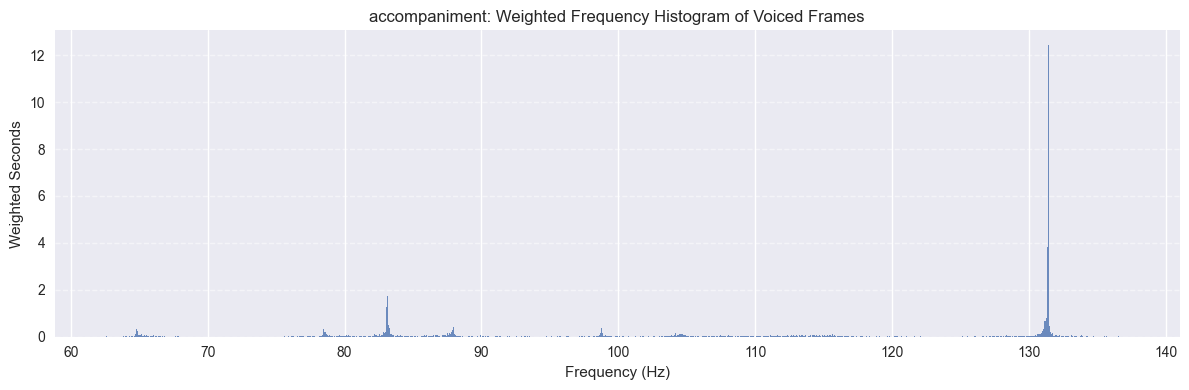

In [59]:
if __name__ == "__main__":
    min_note_str = "G1"
    max_note_str = "C5"
    fmin_hz = librosa.note_to_hz(min_note_str)
    fmax_hz = librosa.note_to_hz(max_note_str)

    # vocal detector: can alter confidence_threshold here (affects detection if recomputing)
    detector_v = SwiftF0(fmin=fmin_hz, fmax=fmax_hz, confidence_threshold=0.98)
    print("-------Vocal analysis--------")
    result_v, valid_freqs_v, cent_hist_v, midi_vals_v = analyze_or_load_with_plots(
        vocals_path,
        detector_v,
        output_prefix="vocals",
        store_as_vocal=True,
        duration=120.0,  # example: analyze only first 120s when recomputing
        override_confidence_threshold=0.95,  # will re-threshold even if CSV loaded
    )

    detector_a = SwiftF0(fmin=fmin_hz, fmax=fmax_hz, confidence_threshold=0.8)
    print("-------Accompaniment analysis --------")
    result_a, valid_freqs_a, cent_hist_a, midi_vals_a = analyze_or_load_with_plots(
        accompaniment_path, detector_a, output_prefix="accompaniment"
    )

In [60]:

_OFFSET_TO_SARGAM = {
    0:  ("Sa",  0, ""),           # 0
    1:  ("Re",  1, "komal"),      # 1
    2:  ("Re",  1, "shuddha"),    # 2
    3:  ("Ga",  2, "komal"),      # 3
    4:  ("Ga",  2, "shuddha"),    # 4
    5:  ("Ma",  3, "shuddha"),    # 5
    6:  ("Ma",  3, "tivra"),      # 6 
    7:  ("Pa",  4, ""),           # 7
    8:  ("Dha", 5, "komal"),      # 8
    9:  ("Dha", 5, "shuddha"),    # 9
    10: ("Ni",  6, "komal"),      # 10
    11: ("Ni",  6, "shuddha"),    # 11
}

def _tonic_to_midi_class(tonic):
    """
    Accepts tonic as:
      - int/float: treated as MIDI number (or MIDI class if you mod 12)
      - string like 'C#4' or 'D'  -> converted using librosa.note_to_midi
      - frequency in Hz (float)   -> convert to MIDI via librosa.hz_to_midi
    Returns integer 0..11 = tonic MIDI class
    """
    if tonic is None:
        raise ValueError("tonic must be provided (MIDI number, note name, or Hz)")
    # numeric -> treat as midi or hz heuristically
    if isinstance(tonic, (int, np.integer)):
        return int(tonic) % 12
    if isinstance(tonic, float) or (isinstance(tonic, np.floating)):
        # ambiguous: assume it's a MIDI if > 0 and < 128 and near integer, else treat as Hz
        if 0 <= tonic < 128 and abs(tonic - round(tonic)) < 0.01:
            return int(round(tonic)) % 12
        else:
            midi = librosa.hz_to_midi(float(tonic))
            return int(round(midi)) % 12
    if isinstance(tonic, str):
        # try note_to_midi directly (accepts 'C#4'), if fails try appending octave 4 ('C#' -> 'C#4')
        try:
            midi = librosa.note_to_midi(tonic)
            return int(midi) % 12
        except Exception:
            try:
                midi = librosa.note_to_midi(tonic + "4")
                return int(midi) % 12
            except Exception:
                # try parse as float Hz string
                try:
                    midi = librosa.hz_to_midi(float(tonic))
                    return int(round(midi)) % 12
                except Exception:
                    raise ValueError(f"Unable to interpret tonic: {tonic!r}")
    raise ValueError(f"Unsupported tonic type: {type(tonic)}")


def convert_vocal_sequence_to_sargam(vocal_note_sequence,
                                     tonic,
                                     sargam_names=None,
                                     prefer_unicode=True):
    """
    Convert vocal_note_sequence (list of dicts with keys 'midi_note' or 'pitch_hz') to sargam.
    - tonic: MIDI number, note string, or frequency in Hz (reference tonic)
    - sargam_names: optional list/array of 7 labels for degrees ['Sa','Re','Ga','Ma','Pa','Dha','Ni']
                    if provided, degree_index (0..6) will be mapped to this and modifier appended.
    - prefer_unicode: if True use '♯' and '♭' glyphs for modifiers.
    Returns: list of dicts (new), in same order as input.
    """
    tonic_class = _tonic_to_midi_class(tonic)
    out = []
    # default sargam array if not provided
    if sargam_names is None:
        sargam_names = ['Sa','Re','Ga','Ma','Pa','Dha','Ni']

    # glyphs
    flat = '♭' if prefer_unicode else 'b'
    sharp = '♯' if prefer_unicode else '#'

    for note in vocal_note_sequence:
        # robust MIDI extraction: prefer midi_note if present, else compute from pitch_hz
        midi_val = None
        if 'midi_note' in note and note['midi_note'] is not None:
            try:
                midi_val = float(note['midi_note'])
            except Exception:
                midi_val = None
        if midi_val is None and 'pitch_hz' in note and note['pitch_hz'] is not None:
            try:
                midi_val = float(librosa.hz_to_midi(float(note['pitch_hz'])))
            except Exception:
                midi_val = None
        if midi_val is None:
            # fallback: skip note or set to NaN
            out_note = dict(note)
            out_note.update({
                'midi': None,
                'pc_offset': None,
                'degree_index': None,
                'modifier': None,
                'sargam': None,
                'octave': None,
                'sargam_from_array': None
            })
            out.append(out_note)
            continue

        midi_round = int(np.round(midi_val))
        pc_class = midi_round % 12
        # offset relative to tonic
        offset = (pc_class - tonic_class) % 12   # 0..11
        base_name, degree_idx, modifier = _OFFSET_TO_SARGAM[offset]

        # pretty sargam label
        if modifier == '':
            sargam_label = base_name
        elif modifier == 'komal':
            # use flat symbol on the base (Re♭) or write "(komal)"
            sargam_label = f"{base_name}{flat} (komal)"
        elif modifier == 'tivra':
            sargam_label = f"{base_name}{sharp} (tivra)"
        elif modifier == 'shuddha':
            sargam_label = f"{base_name}"   # explicitly shuddha -> no marker
        else:
            sargam_label = f"{base_name} ({modifier})"

        # map to sargam_names array if user provided one
        try:
            base_from_array = sargam_names[degree_idx]
        except Exception:
            base_from_array = sargam_names[degree_idx % len(sargam_names)]

        if modifier == '':
            sargam_from_array = base_from_array
        elif modifier == 'komal':
            sargam_from_array = f"{base_from_array}{flat} (komal)"
        elif modifier == 'tivra':
            sargam_from_array = f"{base_from_array}{sharp} (tivra)"
        else:
            sargam_from_array = base_from_array

        octave = (midi_round // 12) - 1  # MIDI octave standard: MIDI 60 -> octave 4 => (60//12)-1 = 4

        out_note = dict(note)  # copy original fields
        out_note.update({
            'midi': midi_round,
            'pc_offset': int(offset),
            'degree_index': int(degree_idx),
            'modifier': modifier,
            'sargam': sargam_label,
            'octave': int(octave),
            'sargam_from_array': sargam_from_array
        })
        out.append(out_note)

    return out

sargam = ['Sa','Re','Ga','Ma','Pa','Dha','Ni']
sargam_seq = convert_vocal_sequence_to_sargam(vocal_note_sequence, tonic, sargam_names=sargam)

for n in sargam_seq:
    print(f"{n['start']:.2f}s→{n['end']:.2f}s  MIDI={n['midi']}  {n['sargam']}  (octave {n['octave']})")

12.04s→12.52s  MIDI=52  Ga  (octave 3)
12.52s→12.82s  MIDI=53  Ma  (octave 3)
12.94s→13.05s  MIDI=54  Ma♯ (tivra)  (octave 3)
13.05s→14.54s  MIDI=55  Pa  (octave 3)
14.60s→14.97s  MIDI=56  Dha♭ (komal)  (octave 3)
14.97s→15.14s  MIDI=55  Pa  (octave 3)
15.14s→15.35s  MIDI=53  Ma  (octave 3)
15.42s→17.18s  MIDI=55  Pa  (octave 3)
17.26s→17.43s  MIDI=53  Ma  (octave 3)
17.43s→17.67s  MIDI=55  Pa  (octave 3)
17.67s→17.83s  MIDI=56  Dha♭ (komal)  (octave 3)
17.83s→17.96s  MIDI=55  Pa  (octave 3)
18.04s→18.17s  MIDI=55  Pa  (octave 3)
18.26s→18.38s  MIDI=53  Ma  (octave 3)
18.49s→19.19s  MIDI=52  Ga  (octave 3)
25.77s→26.23s  MIDI=52  Ga  (octave 3)
26.23s→26.68s  MIDI=53  Ma  (octave 3)
26.68s→28.25s  MIDI=55  Pa  (octave 3)
28.33s→28.71s  MIDI=56  Dha♭ (komal)  (octave 3)
28.71s→28.86s  MIDI=55  Pa  (octave 3)
28.86s→29.06s  MIDI=53  Ma  (octave 3)
29.14s→30.89s  MIDI=55  Pa  (octave 3)
30.97s→31.14s  MIDI=53  Ma  (octave 3)
31.14s→31.38s  MIDI=55  Pa  (octave 3)
31.38s→31.54s  MIDI=56  D

In [61]:
import numpy as np
import pandas as pd
import librosa

def load_raga_definitions(csv_path):
    """
    Load raga definitions from CSV file.
    Your format: columns 0-11 are chromatic notes, 'names' column contains raga names.
    
    Returns:
    - raga_df: DataFrame with raga names as index and note presence as binary values
    """
    # Load the CSV
    df = pd.read_csv(csv_path)
    
    # Extract the 12 note columns (0-11) and the names column
    note_columns = [str(i) for i in range(12)]  # ['0', '1', '2', ..., '11']
    notes_data = df[note_columns].values
    
    # Parse the names column which contains lists like ["Jayat"] or ["Bhairavi, Bilaskhani Todi, Asavari (komal re)"]
    raga_names = []
    expanded_notes = []
    
    for i, names_cell in enumerate(df['names']):
        # Remove brackets and quotes, then split by comma
        names_str = str(names_cell).strip('[""]')
        if ', ' in names_str:
            # Multiple ragas in one row - split them
            individual_ragas = [name.strip() for name in names_str.split(', ')]
        else:
            # Single raga
            individual_ragas = [names_str.strip()]
        
        # Add each raga with the same note pattern
        for raga_name in individual_ragas:
            if raga_name and raga_name != 'nan':  # Skip empty names
                raga_names.append(raga_name)
                expanded_notes.append(notes_data[i])
    
    # Create DataFrame with raga names as index
    raga_df = pd.DataFrame(expanded_notes, 
                          index=raga_names, 
                          columns=note_columns)
    
    print(f"Loaded {len(raga_df)} raga definitions:")
    return raga_df

def get_raga_notes(raga_df, raga_name, tonic='C'):
    """
    Get the valid notes for a specific raga relative to the given tonic.
    
    Parameters:
    - raga_df: DataFrame with raga definitions
    - raga_name: Name of the raga (should match index in CSV)
    - tonic: Tonic note (string like 'C', 'D', etc.)
    
    Returns:
    - valid_pcs: List of pitch classes (0-11) that are valid in this raga
    """
    if raga_name not in raga_df.index:
        print(f"Available ragas: {list(raga_df.index)}")
        raise ValueError(f"Raga '{raga_name}' not found in CSV.")
    
    # Get binary array for this raga
    raga_notes = raga_df.loc[raga_name].values.astype(int)
    
    # Convert tonic to pitch class
    if isinstance(tonic, str):
        try:
            tonic_pc = librosa.note_to_midi(tonic + '4') % 12
        except:
            tonic_pc = librosa.note_to_midi(tonic) % 12
    else:
        tonic_pc = int(tonic) % 12
    
    # Find which pitch classes are valid (have value 1)
    base_valid_pcs = np.where(raga_notes == 1)[0]
    
    # Transpose to the actual tonic
    valid_pcs = [(pc + tonic_pc) % 12 for pc in base_valid_pcs]
    
    # Show what notes we found
    note_names = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
    valid_note_names = [note_names[pc] for pc in sorted(valid_pcs)]
    print(f"Raga '{raga_name}' in tonic '{tonic}': {valid_note_names}")
    
    return sorted(valid_pcs)

def snap_to_raga_notes(midi_notes, valid_pcs, max_distance=1.0, discard_far=False):
    """
    Snap MIDI notes to the nearest valid raga notes.
    
    Parameters:
    - midi_notes: Array of MIDI note numbers (can include floats)
    - valid_pcs: List of valid pitch classes (0-11) for the raga
    - max_distance: Maximum semitone distance to snap (default 1.0)
    - discard_far: If True, discard notes more than max_distance away
    
    Returns:
    - corrected_midi: Array of corrected MIDI notes
    - correction_info: List of dicts with correction details
    """
    midi_notes = np.array(midi_notes)
    corrected_midi = []
    correction_info = []
    
    for original_midi in midi_notes:
        if np.isnan(original_midi):
            continue
            
        # Get the pitch class and octave
        original_pc = int(original_midi) % 12
        octave = int(original_midi) // 12
        
        # Find the closest valid pitch class
        distances = []
        for valid_pc in valid_pcs:
            # Calculate distance considering octave wrapping
            dist1 = abs(original_pc - valid_pc)
            dist2 = 12 - dist1  # Distance going the other way around the octave
            min_dist = min(dist1, dist2)
            distances.append((min_dist, valid_pc))
        
        # Get the closest valid pitch class
        min_distance, closest_pc = min(distances, key=lambda x: x[0])
        
        # Check if we should discard this note
        if discard_far and min_distance > max_distance:
            correction_info.append({
                'original_midi': original_midi,
                'original_pc': original_pc,
                'corrected_midi': None,
                'corrected_pc': None,
                'distance': min_distance,
                'action': 'discarded'
            })
            continue
        
        # Calculate the corrected MIDI note
        if min_distance <= max_distance:
            # Determine direction of correction
            if abs(original_pc - closest_pc) <= abs(original_pc - (closest_pc - 12)):
                if abs(original_pc - closest_pc) <= abs(original_pc - (closest_pc + 12)):
                    # Direct path is shortest
                    corrected_midi_note = octave * 12 + closest_pc
                else:
                    # Path via +12 is shorter
                    corrected_midi_note = octave * 12 + closest_pc + 12
            else:
                # Path via -12 is shorter
                corrected_midi_note = octave * 12 + closest_pc - 12
            
            # Ensure we don't go too far from original
            if abs(corrected_midi_note - original_midi) > abs((octave * 12 + closest_pc) - original_midi):
                corrected_midi_note = octave * 12 + closest_pc
            
            corrected_midi.append(corrected_midi_note)
            
            correction_info.append({
                'original_midi': original_midi,
                'original_pc': original_pc,
                'corrected_midi': corrected_midi_note,
                'corrected_pc': closest_pc,
                'distance': min_distance,
                'action': 'corrected' if min_distance > 0 else 'unchanged'
            })
        else:
            # This shouldn't happen with current logic, but just in case
            corrected_midi.append(original_midi)
            correction_info.append({
                'original_midi': original_midi,
                'original_pc': original_pc,
                'corrected_midi': original_midi,
                'corrected_pc': original_pc,
                'distance': 0,
                'action': 'unchanged'
            })
    
    return np.array(corrected_midi), correction_info

def apply_raga_correction_to_notes(note_sequence, raga_df, raga_name, tonic, max_distance=1.0):
    """
    Apply raga-based pitch correction to a sequence of note dictionaries.

    Modified behavior: notes that would be "corrected" (i.e. moved up/down to nearest raga note)
    or explicitly "discarded" are removed from the output. Only notes classified as "unchanged"
    are retained.

    Parameters:
    - note_sequence: List of note dictionaries (like your sargam_seq)
    - raga_df: DataFrame with raga definitions
    - raga_name: Name of the raga
    - tonic: Tonic note
    - max_distance: Maximum correction distance in semitones

    Returns:
    - corrected_sequence: New list of note dictionaries (only 'unchanged' notes kept)
    - correction_stats: Statistics about the corrections applied
    """
    # Get valid notes for this raga
    valid_pcs = get_raga_notes(raga_df, raga_name, tonic)

    corrected_sequence = []
    all_corrections = []

    for note in note_sequence:
        # Extract MIDI note
        original_midi = None
        for key in ['midi', 'midi_note']:
            if key in note and note[key] is not None:
                try:
                    original_midi = float(note[key])
                except Exception:
                    original_midi = None
                break

        if original_midi is None:
            # Record that this note had no MIDI info and skip it
            all_corrections.append({
                'original_midi': None,
                'original_pc': None,
                'corrected_midi': None,
                'corrected_pc': None,
                'distance': None,
                'action': 'no_midi'
            })
            continue

        # Apply correction (we only use the decision, not the corrected value)
        _, correction_info = snap_to_raga_notes([original_midi], valid_pcs, max_distance=max_distance)
        correction = correction_info[0]
        all_corrections.append(correction)

        # Keep only notes that are unchanged (i.e. already conform to raga)
        if correction['action'] == 'unchanged':
            # append original note unchanged (preserve all original fields)
            corrected_sequence.append(note.copy())
        else:
            # drop the note (do not adjust pitch)
            # this removes notes that would have been moved up/down or discarded
            continue

    # Calculate statistics
    total_notes = len(note_sequence)
    corrected_notes_count = len([c for c in all_corrections if c.get('action') == 'corrected'])
    unchanged_notes_count = len([c for c in all_corrections if c.get('action') == 'unchanged'])
    discarded_notes_count = len([c for c in all_corrections if c.get('action') == 'discarded'])
    no_midi_count = len([c for c in all_corrections if c.get('action') == 'no_midi'])

    correction_stats = {
        'total_notes': total_notes,
        'corrected_notes': corrected_notes_count,   # notes that WOULD have been corrected (now removed)
        'unchanged_notes': unchanged_notes_count,
        'discarded_notes': discarded_notes_count,
        'no_midi_notes': no_midi_count,
        'remaining_notes': len(corrected_sequence),
        'valid_pitch_classes': valid_pcs,
        'raga_name': raga_name
    }

    return corrected_sequence, correction_stats, all_corrections

def print_correction_summary(correction_stats, all_corrections):
    """Print a summary of the pitch corrections applied."""
    
    stats = correction_stats
    print("="*60)
    print(f"RAGA-BASED PITCH CORRECTION SUMMARY")
    print("="*60)
    print(f"Raga: {stats['raga_name']}")
    print(f"Valid pitch classes: {stats['valid_pitch_classes']}")
    print(f"")
    print(f"Original notes:    {stats['total_notes']:4d}")
    print(f"Unchanged notes:   {stats['unchanged_notes']:4d} ({stats['unchanged_notes']/stats['total_notes']*100:.1f}%)")
    print(f"Corrected notes:   {stats['corrected_notes']:4d} ({stats['corrected_notes']/stats['total_notes']*100:.1f}%)")
    print(f"Discarded notes:   {stats['discarded_notes']:4d} ({stats['discarded_notes']/stats['total_notes']*100:.1f}%)")
    print(f"Remaining notes:   {stats['remaining_notes']:4d} ({stats['remaining_notes']/stats['total_notes']*100:.1f}%)")
    
    # Show some examples of corrections
    corrected_examples = [c for c in all_corrections if c['action'] == 'corrected'][:10]
    if corrected_examples:
        print(f"\nExample corrections:")
        for i, correction in enumerate(corrected_examples[:5], 1):
            orig_note = librosa.midi_to_note(int(correction['original_midi']))
            corr_note = librosa.midi_to_note(int(correction['corrected_midi']))
            print(f"  {i}. {orig_note} → {corr_note} (distance: {correction['distance']:.1f} semitones)")

raga_df = load_raga_definitions('/Users/saumyamishra/Desktop/intern/summer25/RagaDetection/db/raga_list_final.csv')

# 2. Apply correction to your notes:
corrected_sargam_seq, stats, corrections = apply_raga_correction_to_notes(
    sargam_seq, raga_df, raga_name, tonic, max_distance=1.0
)

print_correction_summary(stats, corrections)

Loaded 133 raga definitions:
Raga 'Bhairav' in tonic 'C': ['C', 'C#', 'E', 'F', 'G', 'G#', 'B']
RAGA-BASED PITCH CORRECTION SUMMARY
Raga: Bhairav
Valid pitch classes: [0, 1, 4, 5, 7, 8, 11]

Original notes:     130
Unchanged notes:    121 (93.1%)
Corrected notes:      9 (6.9%)
Discarded notes:      0 (0.0%)
Remaining notes:    121 (93.1%)

Example corrections:
  1. F♯3 → F3 (distance: 1.0 semitones)
  2. F♯3 → F3 (distance: 1.0 semitones)
  3. D3 → C♯3 (distance: 1.0 semitones)
  4. D♯3 → E3 (distance: 1.0 semitones)
  5. D3 → C♯3 (distance: 1.0 semitones)


Using raga-corrected sargam sequence for phrase detection
Number of corrected notes: 121


/var/folders/dr/7jrw49755h70bsy03x6hy14c0000gn/T/ipykernel_8974/1250758231.py:216: UserWarning: Glyph 9837 (\N{MUSIC FLAT SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/opt/miniconda3/envs/raga/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9837 (\N{MUSIC FLAT SIGN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


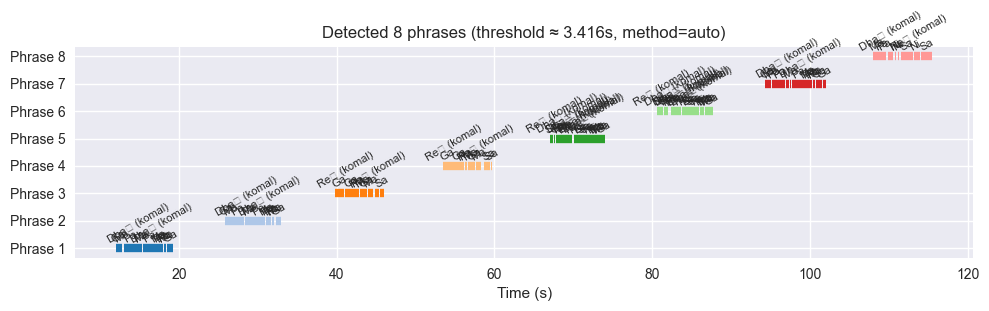


Phrase detection results:
Threshold used: 3.416s
Number of phrases detected: 8

Phrase 1: 12.04s → 19.19s  dur=7.15s  notes=14
    Ga | Ma | Pa | Dha♭ (komal) | Pa | Ma | Pa | Ma | Pa | Dha♭ (komal) | Pa | Pa | Ma | Ga
Phrase 2: 25.77s → 32.92s  dur=7.15s  notes=14
    Ga | Ma | Pa | Dha♭ (komal) | Pa | Ma | Pa | Ma | Pa | Dha♭ (komal) | Pa | Pa | Ma | Ga
Phrase 3: 39.74s → 46.01s  dur=6.27s  notes=9
    Ga | Re♭ (komal) | Ga | Pa | Ma | Ga | Ma | Re♭ (komal) | Sa
Phrase 4: 53.45s → 59.74s  dur=6.29s  notes=10
    Ga | Re♭ (komal) | Ga | Pa | Ma | Ga | Ma | Re♭ (komal) | Sa | Sa
Phrase 5: 67.05s → 74.01s  dur=6.96s  notes=24
    Sa | Re♭ (komal) | Ga | Ma | Pa | Dha♭ (komal) | Ni | Ni | Dha♭ (komal) | Ni | Sa | Re♭ (komal) | Sa | Re♭ (komal) | Sa | Ni | Dha♭ (komal) | Ni | Dha♭ (komal) | Pa
Phrase 6: 80.62s → 87.66s  dur=7.04s  notes=25
    Ni | Sa | Re♭ (komal) | Ga | Ma | Pa | Dha♭ (komal) | Ni | Ni | Dha♭ (komal) | Ni | Sa | Re♭ (komal) | Sa | Re♭ (komal) | Sa | Ni | Dha♭ (komal) |

In [65]:

def _extract_times_and_labels(notes, label_key='sargam'):
    """
    Accepts notes: list-of-dicts with 'start','end' fields. Optionally uses MIDI and sargam labels.
    Returns arrays: starts, ends, mids, labels (strings), original indices.
    """
    starts, ends, mids, labels, idxs = [], [], [], [], []
    for i, n in enumerate(notes):
        if 'start' not in n or 'end' not in n:
            raise ValueError("Each note dict must have 'start' and 'end' keys.")
        starts.append(float(n['start']))
        ends.append(float(n['end']))
        mids.append(int(n.get('midi') if n.get('midi') is not None else (round(n.get('midi_note')) if n.get('midi_note') is not None else np.nan)))
        labels.append(str(n.get(label_key, n.get('sargam', n.get('midi','')))))
        idxs.append(i)
    return np.array(starts), np.array(ends), np.array(mids), labels, np.array(idxs)

def cluster_notes_into_phrases(notes,
                               method='auto',
                               fixed_threshold=None,
                               iqr_factor=1.5,
                               min_phrase_duration=0.25,
                               min_notes_in_phrase=1,
                               merge_gap_threshold=0.1,
                               label_key='sargam',
                               plot_timeline=True,
                               min_auto_threshold=0.3):  # New parameter for minimum auto threshold
    """
    Cluster timestamped notes into phrases.
    - notes: list of dicts with keys 'start' (s), 'end' (s) and optionally 'midi'/'midi_note' and sargam labels.
    - method: 'auto' | 'threshold' | 'kmeans' | 'dbscan'
      - 'auto' tries KMeans (if sklearn available) else robust threshold using IQR.
      - 'threshold' uses fixed_threshold (if None uses iqr method).
      - 'kmeans' uses 2-cluster KMeans on gaps.
      - 'dbscan' treats gaps > eps as breaks; pass eps as fixed_threshold.
    - fixed_threshold: seconds. If supplied it takes priority for 'threshold' or 'dbscan'.
    - iqr_factor: multiplier for IQR in robust threshold.
    - min_phrase_duration: drop phrases shorter than this (seconds) or merge them with neighbors.
    - min_notes_in_phrase: drop phrases with fewer notes (or merge).
    - merge_gap_threshold: after initial segmentation, adjacent phrases separated by a *tiny* silence < this will be merged.
    - label_key: which field in note dict to use for textual label (default 'sargam').
    - min_auto_threshold: minimum threshold for auto method. If auto threshold < this, switch to dbscan with this value.
    Returns: phrases (list of lists of note dicts), breaks_indices, threshold_used
    """
    # defensive copy & sort by start time
    notes_sorted = sorted(notes, key=lambda n: float(n['start']))
    starts, ends, mids, labels, idxs = _extract_times_and_labels(notes_sorted, label_key=label_key)
    n = len(starts)
    if n == 0:
        return [], [], None

    # compute inter-note gaps: end[i-1] -> start[i]
    if n == 1:
        gaps = np.array([])
    else:
        gaps = starts[1:] - ends[:-1]
        # numerical safety
        gaps = np.maximum(gaps, 0.0)

    # pick threshold
    threshold_used = None
    actual_method_used = method  # Track what method was actually used
    
    if method == 'dbscan':
        if fixed_threshold is None:
            raise ValueError("dbscan method requires fixed_threshold (eps in seconds).")
        threshold_used = float(fixed_threshold)

    elif method == 'threshold':
        if fixed_threshold is not None:
            threshold_used = float(fixed_threshold)
        else:
            # robust IQR threshold
            if gaps.size == 0:
                threshold_used = 0.5
            else:
                q1, q3 = np.percentile(gaps, [25, 75])
                iqr = max(q3 - q1, 1e-9)
                threshold_used = float(np.median(gaps) + iqr_factor * iqr)

    elif method in ('kmeans', 'auto'):
        # try KMeans splitting into 2 clusters (short vs long gaps)
        threshold_used = None
        if gaps.size == 0:
            threshold_used = 0.5
        else:
            try:
                from sklearn.cluster import KMeans
                X = gaps.reshape(-1, 1)
                km = KMeans(n_clusters=2, random_state=0, n_init='auto').fit(X)
                centers = km.cluster_centers_.reshape(-1)
                labels_km = km.labels_
                # cluster with smaller center = within-phrase short gaps
                short_cluster = np.argmin(centers)
                long_cluster = np.argmax(centers)
                # threshold = midpoint between the two cluster centers
                auto_threshold = float((centers[short_cluster] + centers[long_cluster]) / 2.0)
                
                # Check if auto threshold is below minimum - if so, switch to dbscan
                if auto_threshold < min_auto_threshold:
                    threshold_used = min_auto_threshold
                    actual_method_used = 'dbscan'
                    print(f"[INFO] Auto threshold ({auto_threshold:.3f}s) below minimum ({min_auto_threshold:.3f}s), switching to dbscan with threshold {min_auto_threshold:.3f}s")
                else:
                    threshold_used = auto_threshold
                    
            except Exception as e:
                # fallback to robust threshold
                q1, q3 = np.percentile(gaps, [25, 75]) if gaps.size else (0.0, 0.0)
                iqr = max(q3 - q1, 1e-9)
                auto_threshold = float(np.median(gaps) + iqr_factor * iqr)
                
                # Check if fallback threshold is below minimum
                if auto_threshold < min_auto_threshold:
                    threshold_used = min_auto_threshold
                    actual_method_used = 'dbscan'
                    print(f"[INFO] Fallback threshold ({auto_threshold:.3f}s) below minimum ({min_auto_threshold:.3f}s), switching to dbscan with threshold {min_auto_threshold:.3f}s")
                else:
                    threshold_used = auto_threshold
                    
                # keep note of fallback
                print(f"[WARN] KMeans unavailable or failed ({e}); using robust IQR threshold {threshold_used:.3f}s")

    else:
        raise ValueError("Unknown method: choose 'auto','threshold','kmeans','dbscan'")

    # segmentation: break where gap > threshold_used
    if gaps.size == 0:
        break_positions = np.array([], dtype=int)
    else:
        break_positions = np.where(gaps > threshold_used)[0]  # indices in gaps; break between note i and i+1 for each index found

    # form phrases
    phrases = []
    start_idx = 0
    for b in break_positions:
        end_idx = b + 1  # inclusive index for phrase slice
        phrase_notes = notes_sorted[start_idx:end_idx]
        phrases.append(phrase_notes)
        start_idx = end_idx
    # last phrase
    phrases.append(notes_sorted[start_idx:])

    # postprocess: merge tiny phrases or those with fewer notes than min_notes_in_phrase
    def _phrase_duration(ph):
        return ph[-1]['end'] - ph[0]['start'] if len(ph) else 0.0

    # 1) merge phrases separated by very small gaps (< merge_gap_threshold)
    if len(phrases) > 1:
        merged = []
        i = 0
        while i < len(phrases):
            cur = phrases[i]
            j = i + 1
            while j < len(phrases):
                gap_between = phrases[j][0]['start'] - cur[-1]['end']
                if gap_between <= merge_gap_threshold:
                    # merge and advance
                    cur = cur + phrases[j]
                    j += 1
                else:
                    break
            merged.append(cur)
            i = j
        phrases = merged

    # 2) merge or drop too-short / too-few-note phrases
    final_phrases = []
    i = 0
    while i < len(phrases):
        ph = phrases[i]
        dur = _phrase_duration(ph)
        if (dur < min_phrase_duration) or (len(ph) < min_notes_in_phrase):
            # try merging with neighbor: prefer merging forward, else backward, else drop
            merged_here = False
            if i + 1 < len(phrases):
                phrases[i+1] = ph + phrases[i+1]
                merged_here = True
            elif i - 1 >= 0:
                final_phrases[-1] = final_phrases[-1] + ph
                merged_here = True
            # if merged, skip adding; else drop
            if merged_here:
                # do not append ph; move to next (which will be merged)
                i += 1
                continue
            else:
                # drop it
                i += 1
                continue
        else:
            final_phrases.append(ph)
            i += 1
    phrases = final_phrases

    # produce break indices in original notes_sorted indexing
    # compute cumulative sizes to reconstruct original break indices
    cum_lens = np.cumsum([len(p) for p in phrases])
    breaks_indices = [int(x) for x in cum_lens[:-1]]  # indices in sorted notes where phrases break

    if plot_timeline:
        fig, ax = plt.subplots(figsize=(10, max(2, len(phrases)*0.4)))
        cmap = plt.get_cmap('tab20')
        for i, ph in enumerate(phrases):
            xs = [n['start'] for n in ph]
            xe = [n['end'] for n in ph]
            mids_local = [int(n.get('midi') if n.get('midi') is not None else (round(n.get('midi_note')) if n.get('midi_note') is not None else np.nan)) for n in ph]
            labels_local = [str(n.get(label_key, n.get('sargam', ''))) for n in ph]
            y = i
            for j, (s, e, lab) in enumerate(zip(xs, xe, labels_local)):
                ax.plot([s, e], [y, y], lw=6, solid_capstyle='butt', color=cmap(i % 20))
                ax.text((s+e)/2, y + 0.12, f"{lab}", ha='center', va='bottom', fontsize=8, rotation=30)
        ax.set_yticks(range(len(phrases)))
        ax.set_yticklabels([f"Phrase {i+1}" for i in range(len(phrases))])
        ax.set_xlabel("Time (s)")
        ax.set_title(f"Detected {len(phrases)} phrases (threshold ≈ {threshold_used:.3f}s, method={actual_method_used})")
        plt.tight_layout()
        plt.show()

    return phrases, breaks_indices, threshold_used

def print_phrases_summary(phrases, label_key='sargam', max_notes=20):
    """Print a summary of detected phrases with their note sequences."""
    for i, ph in enumerate(phrases, 1):
        start = ph[0]['start']
        end = ph[-1]['end']
        dur = end - start
        nnotes = len(ph)
        labels = [str(n.get(label_key, n.get('sargam', ''))) for n in ph]
        preview = " | ".join(labels[:max_notes])
        print(f"Phrase {i}: {start:.2f}s → {end:.2f}s  dur={dur:.2f}s  notes={nnotes}")
        print(f"    {preview}")

try:
    notes_to_use = corrected_sargam_seq
    print("Using raga-corrected sargam sequence for phrase detection")
    print(f"Number of corrected notes: {len(notes_to_use)}")
except NameError:
    print("Warning: corrected_sargam_seq not found, using original sargam_seq")
    notes_to_use = sargam_seq

phrases, breaks, thr = cluster_notes_into_phrases(
    notes_to_use, 
    method='auto', 
    min_auto_threshold=0.5, 
    plot_timeline=True,
    label_key='sargam'
)

print(f"\nPhrase detection results:")
print(f"Threshold used: {thr:.3f}s")
print(f"Number of phrases detected: {len(phrases)}")
print()

print_phrases_summary(phrases)

try:
    if 'corrected_sargam_seq' in locals() and 'sargam_seq' in locals():
        print(f"\nComparison:")
        print(f"Original notes: {len(sargam_seq)}")
        print(f"Corrected notes: {len(corrected_sargam_seq)}")
        print(f"Notes retained after raga correction: {len(corrected_sargam_seq)/len(sargam_seq)*100:.1f}%")
except:
    pass

In [66]:
print("Total notes kept:", len(corrected_sargam_seq))
print("Total phrases:", len(phrases))

Total notes kept: 121
Total phrases: 8


Found 8 phrases from previous analysis.
Using tonic: C
Building corrected transition matrix for aaroh/avroh analysis...
Analyzing Corrected Raga Patterns...
--------------------------------------------------
Found 7 unique sargam notes in the corrected data:
  Sa, Re♭ (komal), Ga, Ma, Pa, Dha♭ (komal), Ni
  Ordered by pitch class: [0, 1, 3, 5, 7, 8, 10]
Built transition matrix with 113 transitions across 8 phrases
Matrix dimensions: 7x7 (only notes present in corrected data)
Found 10 unique ascending patterns
Found 11 unique descending patterns


/opt/miniconda3/envs/raga/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 9837 (\N{MUSIC FLAT SIGN}) missing from font(s) Arial.
  fig.canvas.draw()


/opt/miniconda3/envs/raga/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9837 (\N{MUSIC FLAT SIGN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


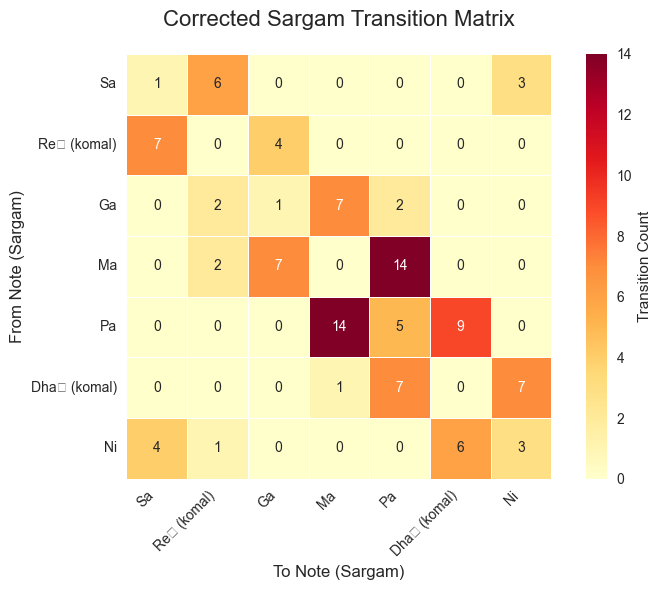

AAROH (ASCENDING) PATTERNS
 1. Ma → Pa                        ( 14 times)
 2. Pa → Dha♭ (komal)              (  9 times)
 3. Ga → Ma                        (  7 times)
 4. Dha♭ (komal) → Ni              (  7 times)
 5. Sa → Re♭ (komal)               (  5 times)
 6. Ni → Sa                        (  4 times)
 7. Re♭ (komal) → Ga               (  3 times)
 8. Ga → Pa                        (  2 times)
 9. Sa → Sa                        (  1 times)
10. Ni → Re♭ (komal)               (  1 times)

AVROH (DESCENDING) PATTERNS
 1. Pa → Ma                        ( 14 times)
 2. Dha♭ (komal) → Pa              (  7 times)
 3. Ma → Ga                        (  7 times)
 4. Re♭ (komal) → Sa               (  7 times)
 5. Ni → Dha♭ (komal)              (  6 times)
 6. Sa → Ni                        (  3 times)
 7. Ga → Re♭ (komal)               (  2 times)
 8. Ma → Re♭ (komal)               (  2 times)
 9. Sa → Re♭ (komal)               (  1 times)
10. Re♭ (komal) → Ga               (  1 times)
11. 

In [67]:
# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter

def extract_corrected_sargam_info(note, tonic):
    """Extract sargam information from corrected notes, using their sargam labels directly."""
    # Use the corrected sargam label if available
    sargam_label = note.get('sargam', '').strip()
    
    # Get MIDI for direction analysis
    midi_note = note.get('midi', note.get('midi_note', None))
    if midi_note is not None:
        midi_note = int(round(float(midi_note)))
    
    # Map sargam labels to pitch class offsets (relative to Sa)
    sargam_to_pc = {
        'Sa': 0,
        'Re♭ (komal)': 1, 'Re♭': 1,
        'Re': 2, 'Re (shuddha)': 2,
        'Ga♭ (komal)': 3, 'Ga♭': 3,
        'Ga': 4, 'Ga (shuddha)': 4,
        'Ma': 5, 'Ma (shuddha)': 5,
        'Ma♯ (tivra)': 6, 'Ma♯': 6,
        'Pa': 7,
        'Dha♭ (komal)': 8, 'Dha♭': 8,
        'Dha': 9, 'Dha (shuddha)': 9,
        'Ni♭ (komal)': 10, 'Ni♭': 10,
        'Ni': 11, 'Ni (shuddha)': 11
    }
    
    # Try exact match first, then fuzzy match
    pc_offset = None
    for sargam_key, pc_val in sargam_to_pc.items():
        if sargam_label == sargam_key:
            pc_offset = pc_val
            break
        elif sargam_key.startswith(sargam_label.split()[0]):  # Match base note
            pc_offset = pc_val
            break
    
    if pc_offset is None:
        # Fallback: try to extract from pc_offset field if available
        if 'pc_offset' in note and note['pc_offset'] is not None:
            pc_offset = int(note['pc_offset']) % 12
        else:
            return None, midi_note, sargam_label
    
    return pc_offset, midi_note, sargam_label

def build_transition_matrix_corrected(phrases, tonic, sargam_labels=None, min_transition_gap=0.1):
    """
    Build transition matrix specifically for corrected raga notes.
    Only uses notes that actually appear in the phrases.
    """
    
    # Collect all unique sargam labels that actually appear in the data
    unique_sargams = set()
    for phrase in phrases:
        for note in phrase:
            sargam = note.get('sargam', '').strip()
            if sargam:
                unique_sargams.add(sargam)
    
    # Define the correct sargam order based on pitch class
    sargam_order_map = {
        'Sa': 0,
        'Re♭ (komal)': 1, 'Re♭': 1,
        'Re': 2, 'Re (shuddha)': 2,
        'Ga♭ (komal)': 3, 'Ga♭': 3,
        'Ga': 4, 'Ga (shuddha)': 4,
        'Ma': 5, 'Ma (shuddha)': 5,
        'Ma♯ (tivra)': 6, 'Ma♯': 6,
        'Pa': 7,
        'Dha♭ (komal)': 8, 'Dha♭': 8,
        'Dha': 9, 'Dha (shuddha)': 9,
        'Ni♭ (komal)': 10, 'Ni♭': 10,
        'Ni': 11, 'Ni (shuddha)': 11
    }
    
    # Sort unique sargams by their pitch class order
    def get_sargam_order(sargam):
        for key, order in sargam_order_map.items():
            if sargam == key or key.startswith(sargam.split()[0]):
                return order
        return 99  # Unknown sargams go to the end
    
    unique_sargams = sorted(list(unique_sargams), key=get_sargam_order)
    print(f"Found {len(unique_sargams)} unique sargam notes in the corrected data:")
    print(f"  {', '.join(unique_sargams)}")
    print(f"  Ordered by pitch class: {[get_sargam_order(s) for s in unique_sargams]}")
    
    # Create mapping from sargam label to matrix index
    sargam_to_idx = {sargam: i for i, sargam in enumerate(unique_sargams)}
    
    # Initialize matrices
    n_notes = len(unique_sargams)
    transition_matrix = np.zeros((n_notes, n_notes), dtype=int)
    transition_details = []
    aaroh_patterns = defaultdict(int)
    avroh_patterns = defaultdict(int)
    
    total_transitions = 0
    
    for phrase_idx, phrase in enumerate(phrases):
        if len(phrase) < 2:
            continue
            
        sorted_phrase = sorted(phrase, key=lambda x: x.get('start', 0))
        
        for i in range(len(sorted_phrase) - 1):
            current_note = sorted_phrase[i]
            next_note = sorted_phrase[i + 1]
            
            # Extract sargam information
            curr_pc, curr_midi, curr_sargam = extract_corrected_sargam_info(current_note, tonic)
            next_pc, next_midi, next_sargam = extract_corrected_sargam_info(next_note, tonic)
            
            if curr_sargam not in sargam_to_idx or next_sargam not in sargam_to_idx:
                continue
            
            # Check time gap
            time_gap = next_note.get('start', 0) - current_note.get('end', 0)
            if time_gap > min_transition_gap * 5:
                continue
            
            # Get matrix indices
            curr_idx = sargam_to_idx[curr_sargam]
            next_idx = sargam_to_idx[next_sargam]
            
            # Update transition matrix
            transition_matrix[curr_idx, next_idx] += 1
            
            # Analyze direction if MIDI available
            if curr_midi is not None and next_midi is not None:
                midi_diff = next_midi - curr_midi
                
                pattern_key = f"{curr_sargam} → {next_sargam}"
                if midi_diff > 0:
                    aaroh_patterns[pattern_key] += 1
                elif midi_diff < 0:
                    avroh_patterns[pattern_key] += 1
            
            # Store transition details
            transition_details.append({
                'phrase_idx': phrase_idx,
                'from_sargam': curr_sargam,
                'to_sargam': next_sargam,
                'from_midi': curr_midi,
                'to_midi': next_midi,
                'direction': 'ascending' if (curr_midi and next_midi and next_midi > curr_midi) 
                           else 'descending' if (curr_midi and next_midi and next_midi < curr_midi)
                           else 'same',
                'time_gap': time_gap,
                'start_time': current_note.get('start', 0),
                'end_time': next_note.get('end', 0)
            })
            
            total_transitions += 1
    
    # Create DataFrame with actual sargam labels
    transition_df = pd.DataFrame(transition_matrix, 
                                index=unique_sargams, 
                                columns=unique_sargams)
    
    print(f"Built transition matrix with {total_transitions} transitions across {len(phrases)} phrases")
    print(f"Matrix dimensions: {n_notes}x{n_notes} (only notes present in corrected data)")
    print(f"Found {len(aaroh_patterns)} unique ascending patterns")
    print(f"Found {len(avroh_patterns)} unique descending patterns")
    
    return transition_matrix, transition_df, aaroh_patterns, avroh_patterns, transition_details, unique_sargams

def analyze_aaroh_avroh(aaroh_patterns, avroh_patterns, top_n=10):
    """Analyze and display the most common ascending and descending patterns."""
    
    print("="*60)
    print("AAROH (ASCENDING) PATTERNS")
    print("="*60)
    
    sorted_aaroh = sorted(aaroh_patterns.items(), key=lambda x: x[1], reverse=True)
    
    if not sorted_aaroh:
        print("No ascending patterns found.")
    else:
        for i, (pattern, count) in enumerate(sorted_aaroh[:top_n], 1):
            print(f"{i:2d}. {pattern:<30} ({count:3d} times)")
    
    print("\n" + "="*60)
    print("AVROH (DESCENDING) PATTERNS") 
    print("="*60)
    
    sorted_avroh = sorted(avroh_patterns.items(), key=lambda x: x[1], reverse=True)
    
    if not sorted_avroh:
        print("No descending patterns found.")
    else:
        for i, (pattern, count) in enumerate(sorted_avroh[:top_n], 1):
            print(f"{i:2d}. {pattern:<30} ({count:3d} times)")
    
    return sorted_aaroh, sorted_avroh

def plot_transition_heatmap_v2(transition_df, title="Note Transition Matrix", 
                              figsize=(10, 8), annot=True, cmap='YlOrRd'):
    """Plot an improved heatmap of the transition matrix."""
    
    # Adjust figure size based on number of notes
    n_notes = len(transition_df.index)
    figsize = (max(8, n_notes * 0.8), max(6, n_notes * 0.8))
    
    plt.figure(figsize=figsize)
    
    # Create heatmap
    sns.heatmap(transition_df, 
                annot=annot, 
                fmt='d', 
                cmap=cmap,
                square=True,
                linewidths=0.5,
                cbar_kws={'label': 'Transition Count'})
    
    plt.title(title, fontsize=16, pad=20)
    plt.xlabel('To Note (Sargam)', fontsize=12)
    plt.ylabel('From Note (Sargam)', fontsize=12)
    
    # Rotate labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.show()

def extract_melodic_sequences(phrases, max_length=8):
    """Extract longer melodic sequences for pattern analysis."""
    
    sequences = []
    
    for phrase_idx, phrase in enumerate(phrases):
        if len(phrase) < 3:
            continue
            
        sorted_phrase = sorted(phrase, key=lambda x: x.get('start', 0))
        
        # Extract sargam sequence
        sargam_sequence = []
        midi_sequence = []
        
        for note in sorted_phrase:
            sargam = note.get('sargam', '').strip()
            if sargam:
                sargam_sequence.append(sargam)
                midi_val = note.get('midi', note.get('midi_note'))
                if midi_val:
                    midi_sequence.append(int(midi_val))
        
        # Break into overlapping windows
        for i in range(len(sargam_sequence) - 2):
            end_idx = min(i + max_length, len(sargam_sequence))
            seq = sargam_sequence[i:end_idx]
            midi_seq = midi_sequence[i:end_idx] if len(midi_sequence) == len(sargam_sequence) else None
            
            if len(seq) >= 3:
                sequences.append({
                    'phrase_idx': phrase_idx,
                    'sequence': seq,
                    'midi_sequence': midi_seq,
                    'length': len(seq),
                    'start_idx': i
                })
    
    return sequences

def find_common_patterns(sequences, min_length=3, min_frequency=2):
    """Find commonly occurring melodic patterns."""
    
    pattern_counts = defaultdict(int)
    
    for seq_info in sequences:
        seq = seq_info['sequence']
        
        # Generate all subsequences of minimum length
        for length in range(min_length, len(seq) + 1):
            for start in range(len(seq) - length + 1):
                pattern = tuple(seq[start:start + length])
                pattern_counts[pattern] += 1
    
    # Filter by minimum frequency
    common_patterns = {pattern: count for pattern, count in pattern_counts.items() 
                      if count >= min_frequency}
    
    # Sort by frequency and length
    sorted_patterns = sorted(common_patterns.items(), 
                           key=lambda x: (x[1], len(x[0])), 
                           reverse=True)
    
    return sorted_patterns

def analyze_raga_patterns_corrected(phrases, tonic='D', top_patterns=15):
    """Complete analysis of raga patterns from corrected phrases."""
    
    print("Analyzing Corrected Raga Patterns...")
    print("-" * 50)
    
    # Build transition matrix for corrected notes only
    matrix, df, aaroh, avroh, details, unique_sargams = build_transition_matrix_corrected(phrases, tonic)
    
    # Plot transition matrix
    plot_transition_heatmap_v2(df, "Corrected Sargam Transition Matrix")
    
    # Analyze patterns
    analyze_aaroh_avroh(aaroh, avroh, top_n=top_patterns)
    
    # Extract melodic sequences
    sequences = extract_melodic_sequences(phrases)
    common_patterns = find_common_patterns(sequences)
    
    print(f"\n{'='*60}")
    print("COMMON MELODIC PATTERNS")
    print("="*60)
    
    if common_patterns:
        for i, (pattern, count) in enumerate(common_patterns[:top_patterns], 1):
            pattern_str = " → ".join(pattern)
            print(f"{i:2d}. {pattern_str:<40} ({count:2d} times)")
    else:
        print("No common patterns found (try reducing min_frequency)")
    
    return matrix, df, aaroh, avroh, details, sequences, common_patterns, unique_sargams

# Check if phrases from previous cell exist
if 'phrases' not in locals() or len(phrases) == 0:
    print("Error: No phrases found. Please run the phrase detection cell first.")
else:
    print(f"Found {len(phrases)} phrases from previous analysis.")
    
    # Use the same tonic as defined earlier
    if 'tonic' not in locals():
        tonic = 'D'
        print(f"Using default tonic: {tonic}")
    else:
        print(f"Using tonic: {tonic}")
    
    print("Building corrected transition matrix for aaroh/avroh analysis...")
    
    # Run the complete analysis
    results = analyze_raga_patterns_corrected(phrases, tonic=tonic, top_patterns=20)
    matrix, df, aaroh_patterns, avroh_patterns, transition_details, sequences, common_patterns, unique_sargams = results
    
    # Additional analysis: Most active notes
    print(f"\n{'='*60}")
    print("NOTE USAGE STATISTICS")
    print("="*60)
    
    # Calculate note activity
    outgoing = df.sum(axis=1)
    incoming = df.sum(axis=0)
    total_activity = outgoing + incoming
    
    print("Most active notes (total transitions):")
    for i, (note, activity) in enumerate(total_activity.sort_values(ascending=False).head(10).items(), 1):
        out_count = outgoing[note]
        in_count = incoming[note]
        print(f"{i:2d}. {note:<20} Total: {activity:3d} (Out: {out_count:3d}, In: {in_count:3d})")
    
    # Summary
    print(f"\nSummary:")
    print(f"Transition matrix shape: {matrix.shape}")
    print(f"Unique sargam notes used: {len(unique_sargams)}")
    print(f"Total phrases analyzed: {len(phrases)}")
    print(f"Total transitions captured: {len(transition_details)}")
    print(f"Unique melodic patterns found: {len(common_patterns)}")
    
    # Check data source
    try:
        if 'corrected_sargam_seq' in locals():
            print(f"✓ Analysis performed on raga-corrected note sequence")
        else:
            print(f"⚠ Analysis performed on original note sequence")
    except:
        pass